## Imports

In [197]:
import scipy.linalg as sci
import numpy as np
import requests
import xml.etree.ElementTree as ET
import csv
import pandas as pd
import sympy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import math
import time

In [198]:
def fetch_page(url):
    response = requests.get(url)
    # 200 is a success code
    if response.status_code == 200:
        return response.content
    else:
        print("Failed to fetch page:", url)
        return None
    

# Function to parse XML data and extract member information
def parse_senate(xml_data):
    members_data = []
    root = ET.fromstring(xml_data)
    members = root.findall('.//members/member')
    for member in members:
        member_data = {
            'name': member.find('member_full').text,
            'vote': member.find('vote_cast').text
        }
        members_data.append(member_data)
    return members_data


# Senate Scraper

In [199]:
senate_df = pd.DataFrame(columns=['Session','Senate','S_R_error','S_D_error'])


In [200]:
# Presidential control: 1 = R, -1 = D
# House/Senate Margin: R-D (More Rs = positive, more Ds = negative)

senate_df = pd.DataFrame(columns=['Session','Senate','S_R_error','S_D_error'])

base_url_senate = "https://www.senate.gov/legislative/LIS/roll_call_votes/vote1011/vote_101_1"

congress_list = np.arange(116,118,0.5)

for l in congress_list:
    congress = int(l)
    if l%1 == .5:
        session = 2
    else:
        session = 1

    print(f'Beginning scrape of Congress {congress}, Session {session}')
    
    c_url = f"https://www.senate.gov/legislative/LIS/roll_call_votes/vote{congress}{session}/vote_{congress}_{session}"

    url_build_1 = c_url

    xml_data_list = []

    i = 1
    while True:
        url = url_build_1 + '_{}.xml'.format("{:05d}".format(i))  # Construct URL with current number
        xml_data = fetch_page(url)

        # Response Validation
        if not xml_data: break
        soup = bs(xml_data,'xml')
        if soup.find('title'):
            break

        if xml_data:
            data=parse_senate(xml_data)
            xml_data_list.append(data)  # Append XML data to the list
        
        time.sleep(1)
        i+=1

    print('Scraping complete')

    # Render the xml list into a Dataframe.

    dict={'Yea':1,'Nay':-1,'Not Voting':0,'Guilty':1,'Not Guilty':-1}

    df=pd.DataFrame(xml_data_list[0]).drop(columns='vote',axis=1) # Create the first column of the dataframe

    # Assemble the vote data
    vote_data = []
    for i in range(len(xml_data_list)):
        column_name = f"vote_{i}"
        temp_d = pd.DataFrame(xml_data_list[i])
        vote_list = temp_d['vote'].map(dict)  # Assuming you have a mapping dictionary defined
        # Append the vote list as a Series to vote_data
        vote_data.append(vote_list.rename(column_name))
    # Concatenate all the vote data into a single DataFrame
    vote_df = pd.concat(vote_data, axis=1)
    df = pd.concat([df, vote_df], axis=1)
    df = df.fillna(0)
    
    print(f'Votes assembled. {len(df)} Senators, {len(df.columns)} votes')

    # Use SVD
    M1=df.drop(columns=['name'],axis=1).to_numpy()
    U,s,Vt=sci.svd(M1)
    U_full=pd.DataFrame(U)

    # Identify the first 2 columns
    U_first_two=U_full[[0,1]] # Grab the first 2 columns
    U_first_two=pd.concat([df['name'].astype(str),U_first_two],axis=1) # Add the names (which are still formatted with party and state)

    # Create the Party and State columns
    U_first_two[['Name','p-s code']] = U_first_two['name'].str.split('(',expand=True)
    U_first_two[['Party','State']] = U_first_two['p-s code'].str.split('-',expand=True)
    U_first_two['Party'] = U_first_two['Party'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)
    U_first_two['State'] = U_first_two['State'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)

    # Clean up excess columns
    U_first_two = U_first_two.drop(columns=['name','p-s code'],axis=1)
    U_first_two.columns=['0','1','Name','Party','State']

    # Find party center
    S_R=U_first_two[U_first_two['Party']=='R'].drop(['Party','State','Name'],axis=1)
    S_D=U_first_two[U_first_two['Party']=='D'].drop(['Party','State','Name'],axis=1)
    Rcenter = np.mean(S_R,axis=0) # Returns a set of 2 values (xy coords)
    Dcenter = np.mean(S_D,axis=0) # Returns a set of 2 values (xy coords)

    # Calculate party errors (RMSE)
    R_error=[]
    for i in range(0,len(S_R)):
        dist=math.dist(S_R.iloc[i],Rcenter)
        R_error.append(dist**2)
    R_RMSE=np.sqrt(np.mean(R_error))
    print(f'R Error: {R_RMSE}')

    D_error=[]
    for i in range(0,len(S_D)):
        dist=math.dist(S_D.iloc[i],Dcenter)
        D_error.append(dist**2)
    D_RMSE=np.sqrt(np.mean(D_error))
    print(f'D Error: {D_RMSE}')

    senate_df.loc[len(senate_df)] = {'Session':(101,1),'Senate':len(S_R)-len(S_D),'S_R_error':R_RMSE,'S_D_error':D_RMSE}


Beginning scrape of Congress 116, Session 1
Scraping complete
Votes assembled. 100 Senators, 429 votes
R Error: 0.020416816359322434
D Error: 0.05387673494270601
Beginning scrape of Congress 116, Session 2
Scraping complete
Votes assembled. 100 Senators, 293 votes
R Error: 0.01929451573902917
D Error: 0.05072821413493985
Beginning scrape of Congress 117, Session 1
Scraping complete
Votes assembled. 100 Senators, 529 votes
R Error: 0.09533626198253528
D Error: 0.08628550688255705
Beginning scrape of Congress 117, Session 2
Scraping complete
Votes assembled. 100 Senators, 422 votes
R Error: 0.06374748099240603
D Error: 0.010377909494450582


In [201]:
senate_df

,Session,Senate,S_R_error,S_D_error
0,"(101, 1)",8,0.020417,0.053877
1,"(101, 1)",8,0.019295,0.050728
2,"(101, 1)",5,0.095336,0.086286
3,"(101, 1)",2,0.063747,0.010378


In [151]:


# Base URL pattern
base_url_senate = "https://www.senate.gov/legislative/LIS/roll_call_votes/vote1011/vote_101_1"

url_build_1 = c_url

xml_data_list = []

i = 1
while True:
    url = url_build_1 + '_{}.xml'.format("{:05d}".format(i))  # Construct URL with current number
    xml_data = fetch_page(url)

    # Response Validation
    if not xml_data: break
    soup = bs(xml_data,'xml')
    if soup.find('title'):
        break

    if xml_data:
        data=parse_senate(xml_data)
        xml_data_list.append(data)  # Append XML data to the list
    
    i+=1

print('Scraping complete')

# Render the xml list into a Dataframe.

dict={'Yea':1,'Nay':-1,'Not Voting':0,'Guilty':1,'Not Guilty':-1}

df=pd.DataFrame(xml_data_list[0]).drop(columns='vote',axis=1) # Create the first column of the dataframe

# Assemble the vote data
vote_data = []
for i in range(len(xml_data_list)):
    column_name = f"vote_{i}"
    temp_d = pd.DataFrame(xml_data_list[i])
    vote_list = temp_d['vote'].map(dict)  # Assuming you have a mapping dictionary defined
    # Append the vote list as a Series to vote_data
    vote_data.append(vote_list.rename(column_name))
# Concatenate all the vote data into a single DataFrame
vote_df = pd.concat(vote_data, axis=1)
df = pd.concat([df, vote_df], axis=1)
df = df.fillna(0)

# Use SVD
M1=df.drop(columns=['name'],axis=1).to_numpy()
U,s,Vt=sci.svd(M1)
U_full=pd.DataFrame(U)

# Identify the first 2 columns
U_first_two=U_full[[0,1]] # Grab the first 2 columns
U_first_two=pd.concat([df['name'].astype(str),U_first_two],axis=1) # Add the names (which are still formatted with party and state)

# Create the Party and State columns
U_first_two[['Name','p-s code']] = U_first_two['name'].str.split(expand=True)
U_first_two[['Party','State']] = U_first_two['p-s code'].str.split('-',expand=True)
U_first_two['Party'] = U_first_two['Party'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)
U_first_two['State'] = U_first_two['State'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)

# Clean up excess columns
U_first_two = U_first_two.drop(columns=['name','p-s code'],axis=1)
U_first_two.columns=['0','1','Name','Party','State']

# Find party center
S_R=U_first_two[U_first_two['Party']=='R'].drop(['Party','State','Name'],axis=1)
S_D=U_first_two[U_first_two['Party']=='D'].drop(['Party','State','Name'],axis=1)
Rcenter = np.mean(S_R,axis=0) # Returns a set of 2 values (xy coords)
Dcenter = np.mean(S_D,axis=0) # Returns a set of 2 values (xy coords)

# Calculate party errors (RMSE)
R_error=[]
for i in range(0,len(S_R)):
   dist=np.sqrt((S_R.iloc[i][0]-Rcenter[0])**2+(S_R.iloc[i][1]-Rcenter[1])**2)
   R_error.append(dist**2)
R_RMSE=np.sqrt(np.mean(R_error))

D_error=[]
for i in range(0,len(S_D)):
   dist=np.sqrt((S_D.iloc[i][0]-Dcenter[0])**2+(S_D.iloc[i][1]-Dcenter[1])**2)
   D_error.append(dist**2)
D_RMSE=np.sqrt(np.mean(D_error))

senate_df.loc[len(senate_df)] = {'Session':(101,1),'Senate':len(S_R)-len(S_D),'S_R_error':R_RMSE,'S_D_error':D_RMSE}



Failed to fetch page: https://www.senate.gov/legislative/LIS/roll_call_votes/vote1012/vote_101_2_00312.xml
Scraping complete


/var/folders/8j/zh4y_t6d2j333cpzqn6skcgh0000gp/T/ipykernel_66547/569300695.py:74: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist=np.sqrt((S_R.iloc[i][0]-Rcenter[0])**2+(S_R.iloc[i][1]-Rcenter[1])**2)
/var/folders/8j/zh4y_t6d2j333cpzqn6skcgh0000gp/T/ipykernel_66547/569300695.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dist=np.sqrt((S_D.iloc[i][0]-Dcenter[0])**2+(S_D.iloc[i][1]-Dcenter[1])**2)


In [189]:
# Render the xml list into a Dataframe.

dict={'Yea':1,'Nay':-1,'Not Voting':0,'Guilty':1,'Not Guilty':-1}

df=pd.DataFrame(xml_data_list[0]).drop(columns='vote',axis=1)


# for i in range(0,len(xml_data_list)):
#     column_name=f"vote_{i}"
#     #print(column_name)
#     temp_d=pd.DataFrame(xml_data_list[i])
#     vote_list = temp_d['vote'].map(dict)
#     df.insert(loc=i+1,column=str(column_name),value=vote_list)
# # df.to_csv(f'SenateData108_1.csv')
# df = df.copy()
# df = df.fillna(0)
# df

vote_data = []

for i in range(len(xml_data_list)):
    column_name = f"vote_{i}"
    temp_d = pd.DataFrame(xml_data_list[i])
    vote_list = temp_d['vote'].map(dict)  # Assuming you have a mapping dictionary defined
    # Append the vote list as a Series to vote_data
    vote_data.append(vote_list.rename(column_name))

# Concatenate all the vote data into a single DataFrame
vote_df = pd.concat(vote_data, axis=1)

# Assuming df is your original DataFrame, you can concatenate it with the new vote_df
df = pd.concat([df, vote_df], axis=1)
df = df.fillna(0)
df

,name,vote_0,vote_1,vote_2,vote_3,vote_4,vote_5,vote_6,vote_7,vote_8,vote_9,vote_10,vote_11,vote_12,vote_13,vote_14,vote_15,vote_16,vote_17,vote_18,vote_19,vote_20,vote_21,vote_22,vote_23,vote_24,vote_25,vote_26,vote_27,vote_28,vote_29,vote_30,vote_31,vote_32,vote_33,vote_34,vote_35,vote_36,vote_37,vote_38,vote_39,vote_40,vote_41,vote_42,vote_43,vote_44,vote_45,vote_46,vote_47,vote_48,...,vote_378,vote_379,vote_380,vote_381,vote_382,vote_383,vote_384,vote_385,vote_386,vote_387,vote_388,vote_389,vote_390,vote_391,vote_392,vote_393,vote_394,vote_395,vote_396,vote_397,vote_398,vote_399,vote_400,vote_401,vote_402,vote_403,vote_404,vote_405,vote_406,vote_407,vote_408,vote_409,vote_410,vote_411,vote_412,vote_413,vote_414,vote_415,vote_416,vote_417,vote_418,vote_419,vote_420,vote_421,vote_422,vote_423,vote_424,vote_425,vote_426,vote_427
0,Alexander (R-TN),1,1,1,1,-1,-1,0,-1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,1,...,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,Baldwin (D-WI),-1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,...,-1,-1,1,1,-1,1,1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,1,1,1,1,-1,-1,-1,1,-1,-1,1,1,1,1,1,1,1,1,1,-1,1,-1,-1,1,1,1,1,1,1,1,1,1
2,Barrasso (R-WY),1,1,1,1,-1,-1,1,1,1,-1,1,1,1,1,1,1,1,-1,-1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,1,1
3,Bennet (D-CO),-1,-1,-1,-1,1,1,-1,1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,...,-1,-1,1,1,-1,-1,1,0,0,0,0,0,0,0,0,-1,-1,-1,1,0,1,1,-1,-1,-1,1,-1,1,-1,1,1,1,1,1,1,1,1,-1,1,-1,1,-1,1,1,1,1,1,1,1,1
4,Blackburn (R-TN),1,1,1,1,-1,-1,1,1,1,-1,1,1,1,1,1,1,1,1,1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,-1,1
5,Blumenthal (D-CT),-1,-1,-1,-1,1,1,-1,1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,...,-1,-1,1,1,-1,-1,1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,-1,-1,1,1,1,-1,-1,1,1,-1,-1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,1,1,1,1,1,1,1,1,1
6,Blunt (R-MO),1,1,1,1,-1,-1,1,1,1,-1,1,1,0,1,1,1,1,1,1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,Booker (D-NJ),-1,-1,-1,-1,1,1,-1,-1,-1,1,0,-1,-1,-1,-1,-1,1,0,0,1,1,1,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Boozman (R-AR),1,1,1,-1,1,1,1,1,1,-1,1,1,1,1,1,1,1,1,1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,1,1,1
9,Braun (R-IN),1,1,1,1,-1,-1,1,1,1,-1,1,1,1,1,1,1,1,-1,-1,-1,1,1,1,1,1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,1,1,1,1,1,1,1,1,-1,-1,1,-1,-1


In [191]:
# Use SVD to find clusters

M1=df.drop(columns=['name'],axis=1).to_numpy()

U,s,Vt=sci.svd(M1)

U_full=pd.DataFrame(U)

U_first_two=U_full[[0,1]]
U_first_two=pd.concat([df['name'].astype(str),U_first_two],axis=1)

# Create the Party and State columns
U_first_two[['Name','p-s code']] = U_first_two['name'].str.split('(',expand=True)
U_first_two[['Party','State']] = U_first_two['p-s code'].str.split('-',expand=True)
U_first_two['Party'] = U_first_two['Party'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)
U_first_two['State'] = U_first_two['State'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)

U_first_two = U_first_two.drop(columns=['name','p-s code'],axis=1)
U_first_two.columns=['0','1','Name','Party','State']

U_first_two

,0,1,Name,Party,State
0,-0.106997,-0.039541,Alexander,R,TN
1,0.061931,-0.152349,Baldwin,D,WI
2,-0.135642,-0.027097,Barrasso,R,WY
3,0.031697,-0.111678,Bennet,D,CO
4,-0.131302,-0.014666,Blackburn,R,TN
5,0.073797,-0.133568,Blumenthal,D,CT
6,-0.130889,-0.054182,Blunt,R,MO
7,0.039965,-0.029514,Booker,D,NJ
8,-0.132340,-0.054562,Boozman,R,AR
9,-0.131123,-0.007899,Braun,R,IN


In [177]:
# Find party center statistics

S_R=U_first_two[U_first_two['Party']=='R'].drop(['Party','State','Name'],axis=1)
S_D=U_first_two[U_first_two['Party']=='D'].drop(['Party','State','Name'],axis=1)
Rcenter = np.mean(S_R,axis=0)
print(Rcenter)
Dcenter = np.mean(S_D,axis=0)
print(Dcenter)

R_error=[]
for i in range(0,len(S_R)):
   dist=math.dist(S_R.iloc[i],Rcenter)
   R_error.append(dist**2)
R_RMSE=np.sqrt(np.mean(R_error))
print(R_RMSE)

D_error=[]
for i in range(0,len(S_D)):
   dist=math.dist(S_D.iloc[i],Dcenter)
   D_error.append(dist**2)
D_RMSE=np.sqrt(np.mean(D_error))
print(D_RMSE)

senate_df.loc[len(senate_df)] = {'Session':2024,'Senate':len(S_R)-len(S_D),'S_R_error':R_RMSE,'S_D_error':D_RMSE}

senate_df

0   -0.077063
1   -0.077075
dtype: float64
0   -0.109580
1    0.011392
dtype: float64
0.08985706856869476
0.08888383326653669


,Session,Senate,S_R_error,S_D_error
0,2024,-10,NaN,NaN
1,2024,-10,0.089857,0.088884
2,2024,-10,0.089857,0.088884


In [160]:
S_R.iloc[0]

0   -0.099183
1    0.053461
Name: 1, dtype: float64

# Plotting Reference Code

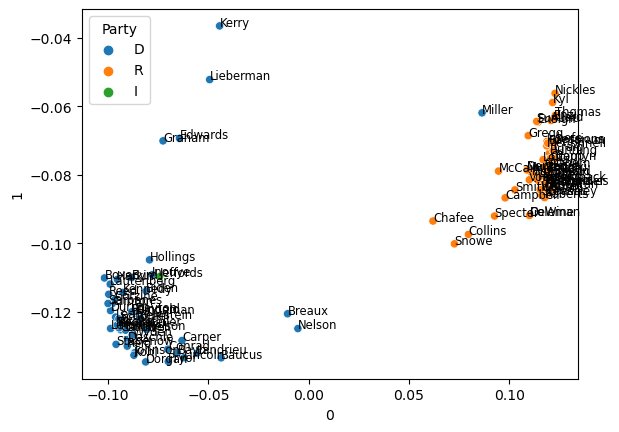

In [66]:
# Plot the senators
p1 = sns.scatterplot(data=U_first_two,x='0',y='1',hue='Party')

for i in range(0,len(U_first_two)):
    p1.text(x=U_first_two['0'].iloc[i], y=U_first_two['1'].iloc[i], 
    s=U_first_two['Name'].iloc[i], horizontalalignment='left', 
    size='small', color='black')
plt.show()